# A Random Walk Through Time Series Forecasting and Prediction

<br>
<br>
<b>
<p style="text-align:center;">Douglas Cooper</p>
<p style="text-align:center;">Innovative Algorithms, LLC</p>
<p style="text-align:center;">cPacket Networks</p>
</b>
<br>
<br>


## Introduction

### What is a Time Series?


>#### Any sample of data ordered by time may be considered time series data.
>#### Time Series Analysis includes the temporal aspect of the data in the analysis
>#### Time Series Models are used to represent the observed data
>#### Time Series Forecasts (Predictions) project the model forward in time



The essential difference between modeling data via time series methods or using "traditional" statistical methods is the following: Time series analysis accounts for the fact that data points taken over time may have an internal temporal structure (such as autocorrelation, trend or seasonal variation) that should be accounted for.
<br>
<br>
### Note About This Presentation

This presentation is a compilation of work by other people (plus some small pieces that I added).
Although there are many good sources of information, for this presentation, I decided to follow the online book from NIST called the [Engineering Statistics Handbook](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm "Introduction to Time Series Analysis").  In case you want to learn more, I will include links to other sources of information near the end of this Jupyter Notebook.

The documentation is scant.  That is because I am counting on filling in details verbally.  In the future, I might attempt to improve the document so that it is "self-contained."



In [50]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
import seaborn as sns

import sys # only needed to determine the python version number
import matplotlib # only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 2.7.13 |Anaconda custom (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]
Pandas version 0.19.2
Matplotlib version 2.0.0


In [51]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.

    Null hypothesis: the series is non-stationary.dfsmt
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).

    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html

    window argument is only required for plotting rolling functions. Default=4.
    '''

    # set defaults (from function page)
    if regression is None:
        regression = 'c'

    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))

    if plot:
        if window is None:
            window = 4
        # Determing rolling statistics
        roll = timeseries.rolling(window=window, center=False)
        rolmean = roll.mean()
        rolstd = roll.std()

        # Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)

    # Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                             ])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
        
    return dfoutput

def rollingplot(series, window=30, title='', figsize=(14, 8)):
    '''Plot a time series along with its rolling mean and 1 std'''
    fig = plt.figure(figsize=figsize)
    
    r = series.rolling(window)
    m = r.agg(['mean', 'std'])
    ax = m['mean'].plot()
    ax.fill_between(m.index, m['mean']-m['std'], m['mean']+m['std'], alpha=0.25)
    plt.tight_layout()
    sns.despine()

def rollingbands(ts_mean, ts_std, window=30, title='', figsize=(14, 8)):
    '''Plot a time series along with its rolling mean and 1 std'''
    fig = plt.figure(figsize=figsize)
    
    rm = ts_mean.rolling(window)
    rs = ts_std.rolling(window)
    ax = ts_mean.plot()
    ax.fill_between(ts_mean.index, rm.mean()-rs.mean(), rm.mean()+rs.mean(), alpha=0.25)
    plt.tight_layout()
    sns.despine()

In [52]:
def choose_AR_model_order(ts, maxlag=6, ic='bic'):
    '''Return the AR model order that minimizes the chosen information criterion'''
    ar_model_order = sm.tsa.AR(ts).select_order(maxlag=maxlag, ic=ic)
    return ar_model_order

# def choose_ARMA_model_order(ts):
#     '''Return the ARMA model order, (p, q) tuple, that minimizes the chosen Bayesian Information Criterion'''
#     result = smt.stattools.arma_order_select_ic(ts)
#     #return result[result.keys()[0]]
#     return result.bic_min_order

def abs_diff(Y):
    return np.sum(np.abs(np.diff(Y)))

def abs_error(Y, Yhat):
    '''Return the absolute error between the data, Y, and the model output, Yhat'''
    return np.sum(np.abs(np.subtract(Y, Yhat)))

def rms_error(Y, Yhat):
    '''Return the root mean squared error between the data, Y, and the model output, Yhat'''
    return np.sqrt(np.mean((Y-Yhat)**2))

def mean_error(Y, Yhat):
    '''Return the mean error between the data, Y, and the model output, Yhat'''
    return np.mean(np.subtract(Y, Yhat))

def mean_abs_diff(Y):
    return np.mean(np.abs(np.diff(Y)))

def mean_abs_error(Y, Yhat):
    '''Return the mean absolute error between the data, Y, and the model output, Yhat'''
    return np.mean(np.abs(np.subtract(Y, Yhat)))

def rate_prediction(y_actual, y_predicted, rtol=1.0e-5, atol=1.0e-8, equal_nan=True):
    '''Rate the predictions, given the last y value, the future y values and the predicted y values.
    :param: y_actual: The last observed data point, followed by the "future data".
    :param: y_predicted: The predictions for the data, starting.
    :param: rtol: relative tolerance for considering the predicted values equal to the observed future data.
    :param: atol: absolute tolerance for considering the predicted values equal to the observed future data.
    :param: equal_nan: True means treat two nans (one in y_actual, one in y_predicted) as equal.
    '''
    
    # Define largest rating
    max_rating = 1.0 / atol
    
    # Prevent divide by zero.  If the prediction matches the future data to tolerance, return a large number
    if np.allclose(y_actual[1:], y_predicted[1:], rtol=rtol, atol=atol, equal_nan=equal_nan):
        return max_rating
    
    prediction_error = abs_error(y_actual[1:], y_predicted[1:])

    # Calculate the Naive prediction error for comparison
    naive_error = np.sum(np.abs(np.diff(y_actual)))
    return min(max_rating, naive_error / prediction_error)

In [53]:
# Utility DataFrame Manipulation Functions
def use_first_column_as_index(df, datetime_format='%Y'):
    """Use the first column of the DataFrame as the index"""

    if df.empty or 0 == len(df.columns):
        return None

    # TODO: Catch exceptions resulting from invalid format
    c = df.columns[0]
    df[c] = pd.to_datetime(df[c], format=datetime_format)
    df.set_index(c, inplace=True)
    return None


# Utility CSV Reader Class
class DataReaderCSV:
    """A Class with a method to read a csv file and return a dataframe."""
    
    def __init__(self):
        self.folder = None
        
    def set_folder(self, folder_name):
        """Set the name of the folder to read from"""
        
        if os.path.isdir(folder_name):
            self.folder = folder_name
    
    def read_csv(self, file_name):
        """Read a csv file from the current folder"""
        
        df = None
        if self.folder and os.path.isdir(self.folder):
            file_path = os.path.join(self.folder, file_name)
        elif not self.folder:
            file_path = file_name
        
        if os.path.exists(file_path) and not os.path.isdir(file_path):
            df = pd.read_csv(file_path, parse_dates=True)
        else:
            raise ValueError('DataReaderCSV.read_csv returned an empty DataFrame')

        return df


In [54]:
my_reader = DataReaderCSV()
my_reader.set_folder("C:/data/timeseries")
df_sales = my_reader.read_csv("PC_Sales.csv")

use_first_column_as_index(df_sales)
print df_sales.head(15)

            Millions of Dollars    Mean  Error  Squared Error
Year                                                         
1985-01-01               46.163  48.676 -2.513          6.313
1986-01-01               46.998  48.676 -1.678          2.814
1987-01-01               47.816  48.676 -0.860          0.739
1988-01-01               48.311  48.676 -0.365          0.133
1989-01-01               48.758  48.676  0.082          0.007
1990-01-01               49.164  48.676  0.488          0.239
1991-01-01               49.548  48.676  0.872          0.761
1992-01-01               48.915  48.676  0.239          0.057
1993-01-01               50.315  48.676  1.639          2.688
1994-01-01               50.768  48.676  2.092          4.378



## Let's pretend the last 3 columns (Mean, Error, Squared Error) are not in this data set, and treat this as a single time series of PC Sales (in dollars) per year ...
<br>


In [55]:
ts_income = pd.Series(data=df_sales['Millions of Dollars'].get_values(), index=df_sales.index)
print ts_income

Year
1985-01-01    46.163
1986-01-01    46.998
1987-01-01    47.816
1988-01-01    48.311
1989-01-01    48.758
1990-01-01    49.164
1991-01-01    49.548
1992-01-01    48.915
1993-01-01    50.315
1994-01-01    50.768
dtype: float64


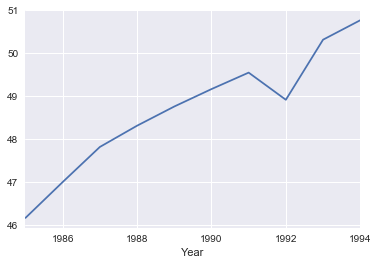

In [56]:
ts_income.plot()

### Some (very) basic methods for predicting the next value

#### Use the mean value

In [57]:
ts_mean = pd.Series(ts_income.mean(), index=ts_income.index)

# The above uses broadcasting.
# Without broadcasting, we'd need to code something along these lines...
# years = ts_income.index
# number_of_years = len(years)
# vals = np.full(number_of_years, ts_income.mean())
# ts_mean = pd.Series(data=vals, index=years)

ts_error = pd.Series(data = ts_income - ts_mean, index = ts_income.index)
ts_error_squared = ts_error.pow(2)

In [58]:
# For output Purposes, put the two series into a dataframe
df_error = pd.DataFrame(data=np.array([ts_error, ts_error_squared]).T, index=ts_error.index, columns=['Error', 'Squared Error'])
print df_error

             Error  Squared Error
Year                             
1985-01-01 -2.5126       6.313159
1986-01-01 -1.6776       2.814342
1987-01-01 -0.8596       0.738912
1988-01-01 -0.3646       0.132933
1989-01-01  0.0824       0.006790
1990-01-01  0.4884       0.238535
1991-01-01  0.8724       0.761082
1992-01-01  0.2394       0.057312
1993-01-01  1.6394       2.687632
1994-01-01  2.0924       4.378138


In [59]:
print rms_error(ts_income.get_values(), ts_mean.get_values())

1.34643360029


#### Use the last value.  (This is called the "Naive" Predictor.)

In [60]:
naive_error = ts_income.diff(1)
print naive_error

Year
1985-01-01      NaN
1986-01-01    0.835
1987-01-01    0.818
1988-01-01    0.495
1989-01-01    0.447
1990-01-01    0.406
1991-01-01    0.384
1992-01-01   -0.633
1993-01-01    1.400
1994-01-01    0.453
dtype: float64


In [61]:
print naive_error.abs().mean()

0.652333333333


#### Note
We are interested in attempting to doing better than using the mean or last value as a predictor.  Therefore it is common to rate a predictor by dividing the sum of the absolute errors of the chosen predictor by the sum of the absolute errors of the "naive predictor" (using the last value).  A number at or above 1 indicates the chosen predictor is performing poorly.  A perfect predictor would have a rating of zero.

### Let's plot the time series
* tsplot has 4 subplots (defined at the top of this file)
 * The time series itself
 * The histogram of values
 * The Autocorrelation values
 * The Partial Autocorrelation values

(<matplotlib.axes._subplots.AxesSubplot at 0x108f8198>,
 <matplotlib.axes._subplots.AxesSubplot at 0xe1120f0>)

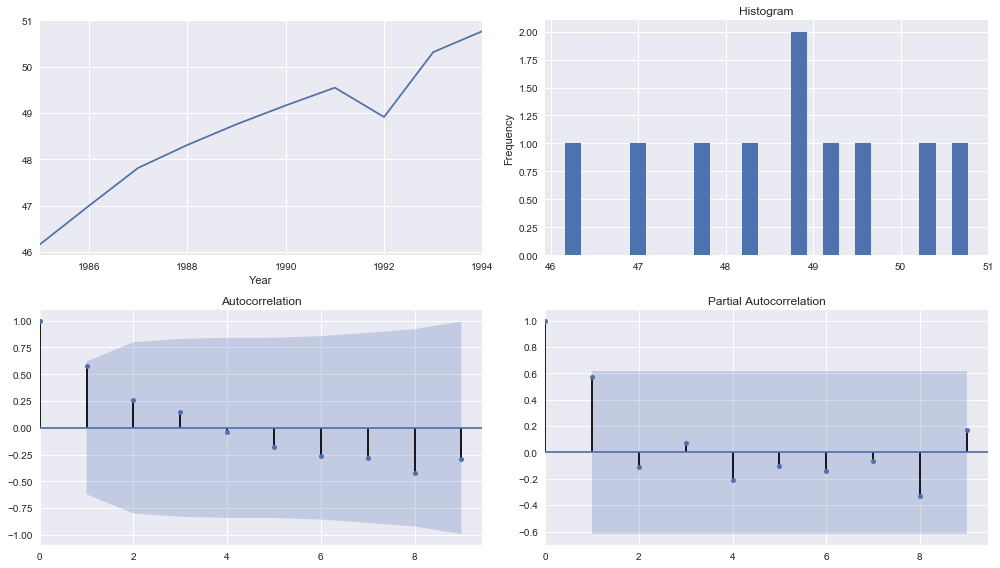

In [62]:
tsplot(ts_income)

### Plot the Time Series With Mean

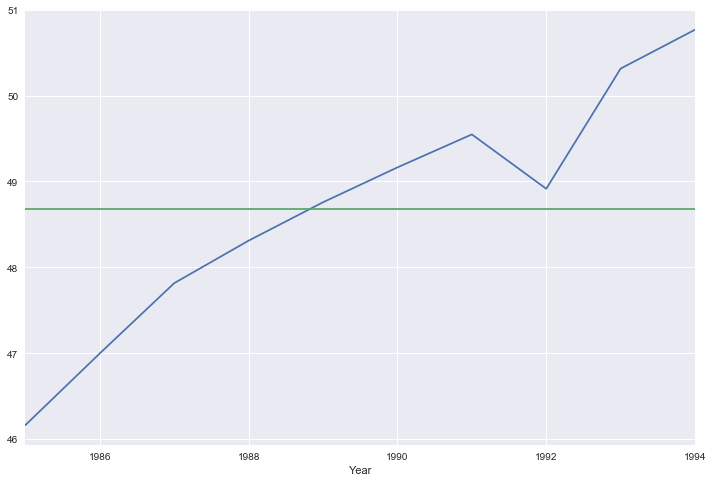

In [63]:
ts_income.plot(figsize=(12,8))
ts_mean.plot()
sns.set_style({'axes.axisbelow': True})
sns.despine()
plt.show()

### Some Thoughts

* The Simple Average of all past observations might only be a useful estimate for forecasting when the data shows no trends.
* The average weights all observations equally.
* In this example, using the previous value is a better representation of the time series than using the mean value

### Plot the Time Series "Prediction Using Last Data Point"

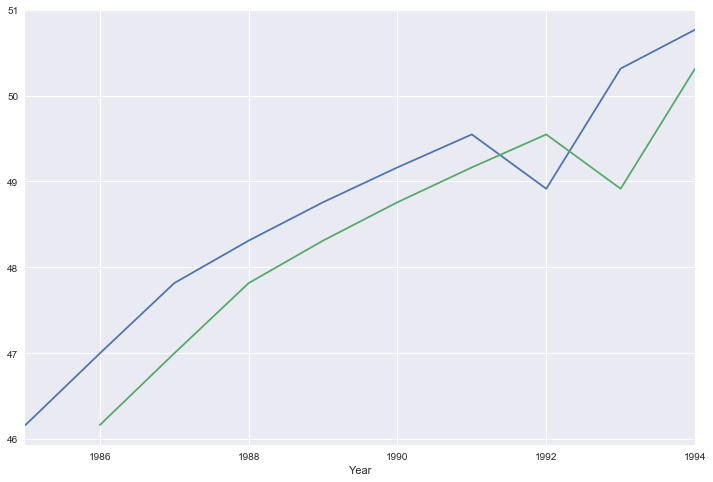

In [64]:
ts_income.plot(figsize=(12,8))
ts_income.shift(1).plot()
sns.set_style({'axes.axisbelow': True})
sns.despine()
plt.show()

In [65]:
last_rmse = rms_error(ts_income[1:], ts_income.shift(periods=1)[1:])
mean_rmse = rms_error(ts_income.get_values(), ts_mean.get_values())
print last_rmse, mean_rmse

0.721832005694 1.34643360029


In [66]:
last_mae = mean_abs_error(ts_income[1:], ts_income.shift(periods=1)[1:])
mean_mae = mean_abs_error(ts_income.get_values(), ts_mean.get_values())
print last_mae, mean_mae

0.652333333333 1.08288


### We should be able to do better than using the last observed value

### Let's look at a way of weighing recent data more heavily than past data ...

#### Moving Averages
* Use a time window to filter out older data
* Use all data, but with decreasing weights to emphasize recent data over older data


In [67]:
ts_roll = ts_income.rolling(window = 3)
ts_roll_mean = ts_roll.mean()
ts_roll_max = ts_roll.max()
ts_roll_min = ts_roll.min()

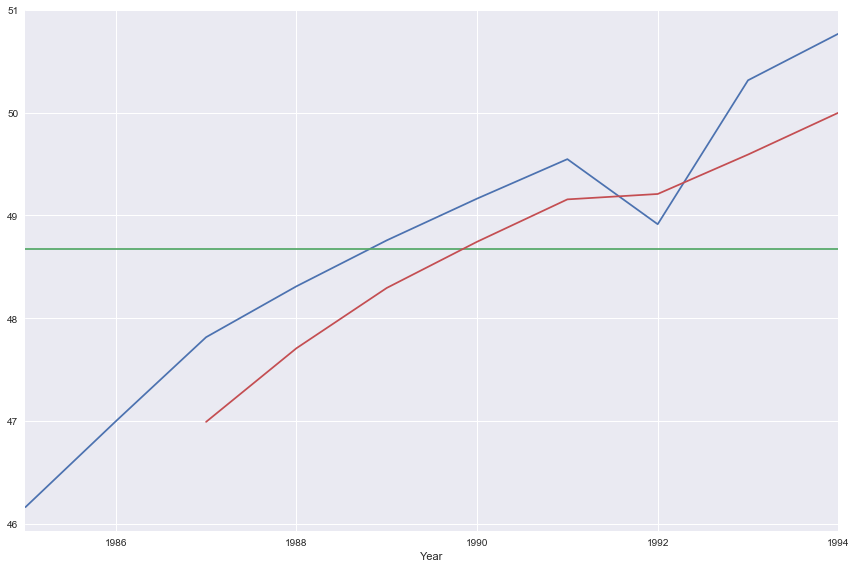

In [68]:
fig = plt.figure(figsize=(12,8))
ts_income.plot()
ts_mean.plot()
ts_roll_mean.plot()
plt.tight_layout()
sns.set_style({'axes.axisbelow': True})
sns.despine()
plt.show()

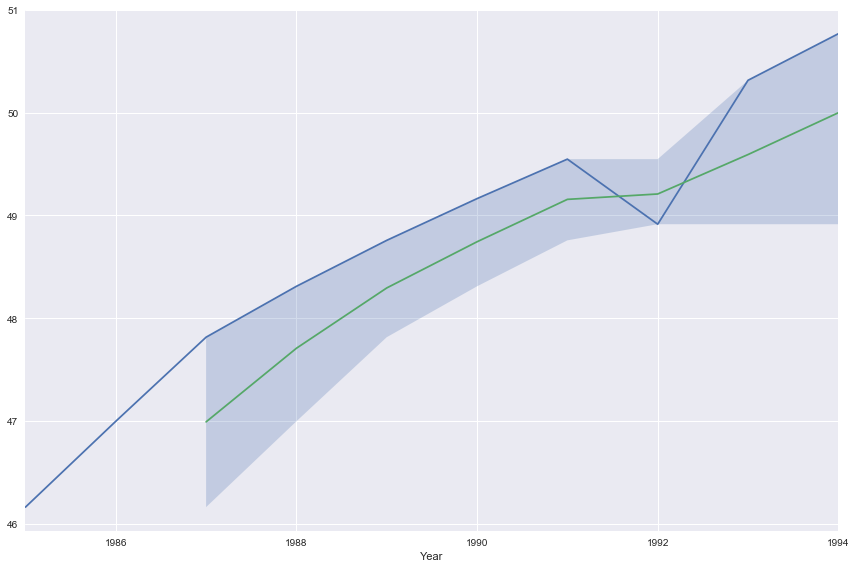

In [69]:
fig = plt.figure(figsize=(12,8))
ts_income.plot()
ax = ts_roll_mean.plot()
ax.fill_between(ts_roll_mean.index, ts_roll_min, ts_roll_max, alpha=0.25)
plt.tight_layout()
sns.set_style({'axes.axisbelow': True})
sns.despine()
plt.show()

#### The rolling window supports a number of different [weighted window types](http://pandas.pydata.org/pandas-docs/stable/computation.html "Rolling Windows").  Let's try the triangular window for fun.
Note that only two aggregation functions are supported for these window types: sum and mean

In [70]:
ts_triang = ts_income.rolling(window = 3, win_type="triang")
ts_triang_mean = ts_triang.mean()

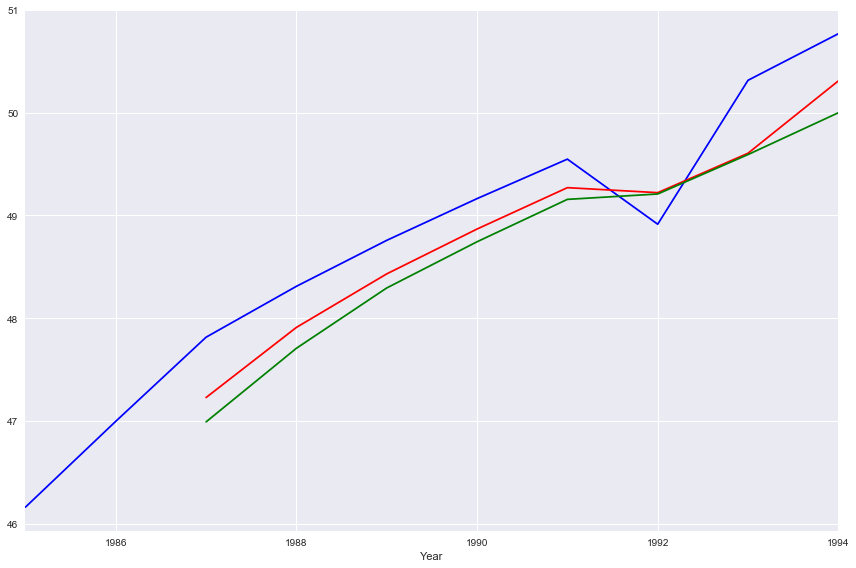

In [71]:
fig = plt.figure(figsize=(12,8))
ts_income.plot(color='blue')
ts_triang_mean.plot(color='red')
ts_roll_mean.plot(color='green')
plt.tight_layout()
sns.set_style({'axes.axisbelow': True})
sns.despine()
plt.show()

## Exponential Smoothing

* Assigns exponentially decreasing weights as the observation gets older
* Requires choosing one or more smoothing parameters
<br>

### Single Exponential Smoothing

For any time period t, the smoothed value $S_t$ is found by computing

$$ S_t = \alpha y_{t-1} + (1-\alpha) S_{t-1}$$
where
$$ 0 < \alpha <= 1 $$

This is the basic equation of exponential smoothing.
The parameter $\alpha$ is called the smoothing constant.


In [72]:
df2 = my_reader.read_csv("Example_Single_EWMA.csv")
print df2.head(15)

    Time  Y(t)  S(t), alpha = 0.1  Error  Squared Error
0      1    71                NaN    NaN            NaN
1      2    70              71.00  -1.00           1.00
2      3    69              70.90  -1.90           3.61
3      4    68              70.71  -2.71           7.34
4      5    64              70.44  -6.44          41.47
5      6    65              69.80  -4.80          23.04
6      7    72              69.32   2.68           7.18
7      8    78              69.52   8.42          70.90
8      9    75              70.43   4.57          20.88
9     10    75              70.88   4.12          16.97
10    11    75              71.29   3.71          13.76
11    12    70              71.67  -1.67           2.79


In [73]:
Y = pd.Series(data=df2.loc[:,"Y(t)"].get_values(), index=df2.loc[:,"Time"].get_values())
Y_mean = pd.Series(data=np.mean(Y.get_values()), index=Y.index)

In [74]:
Y_rolling = Y.rolling(window=3)
Y_rolling_max = Y_rolling.max()
Y_rolling_mean = Y_rolling.mean()
Y_rolling_min = Y_rolling.min()

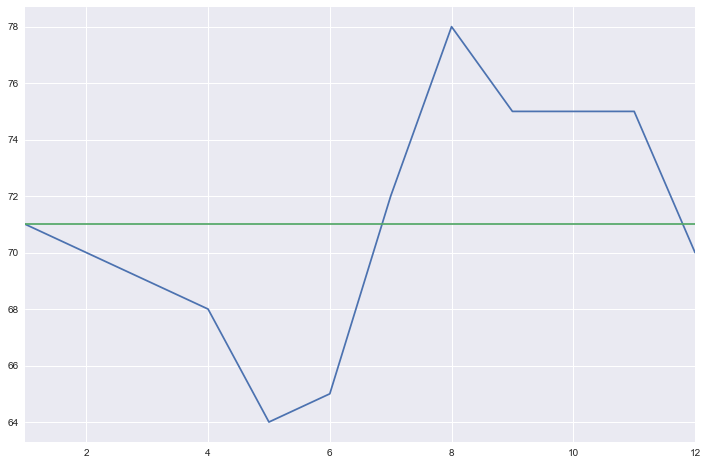

In [75]:
Y.plot(figsize=(12,8))
Y_mean.plot()
sns.despine()
plt.show()

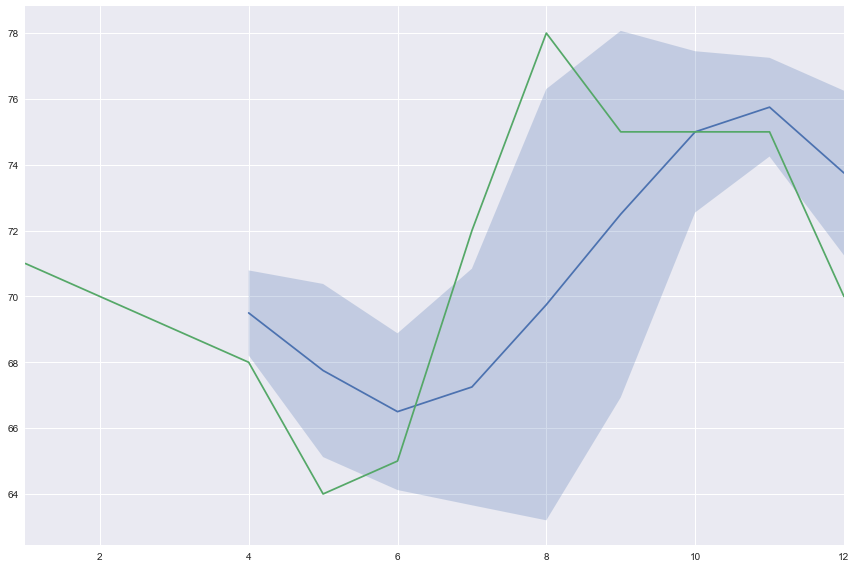

In [76]:
rollingplot(Y, window=4, title='Rolling Plot', figsize=(12,8))
Y.plot()
plt.show()

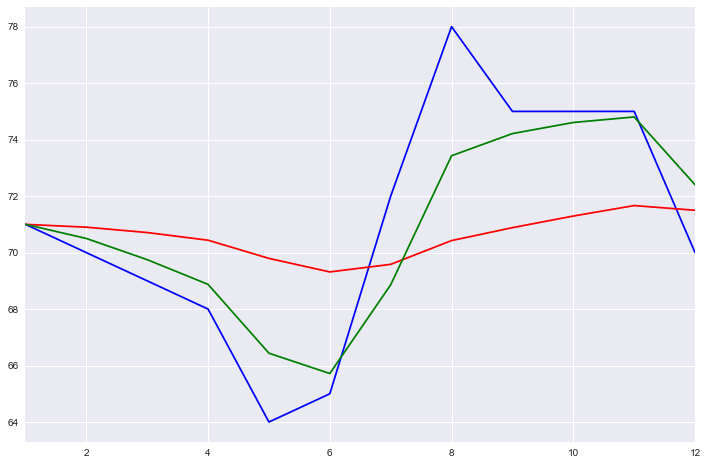

In [77]:
Y_ewm_10 = Y.ewm(alpha=0.1, adjust=False)
Y_ewma_10 = Y_ewm_10.mean()
Y_ewm_50 = Y.ewm(alpha=0.5, adjust=False)
Y_ewma_50 = Y_ewm_50.mean()
Y.plot(color='blue', figsize=(12,8))
Y_ewma_10.plot(color='red')
Y_ewma_50.plot(color='green')
plt.show()

### How would we use this EWMA for a 1 step ahead prediction?

$$ S_{t+1} = \alpha y_t + (1-\alpha)S_t = S_t + \alpha (y_t - S_t) = S_t + \alpha \epsilon_t $$

### How about two steps ahead or more?
* Bootstrapping: Essentially assume that $y_{t+h} = y_t$ for all time steps $h$.

$$ S_{t+2} = \alpha y_t + (1 - \alpha) S_{t+1} $$

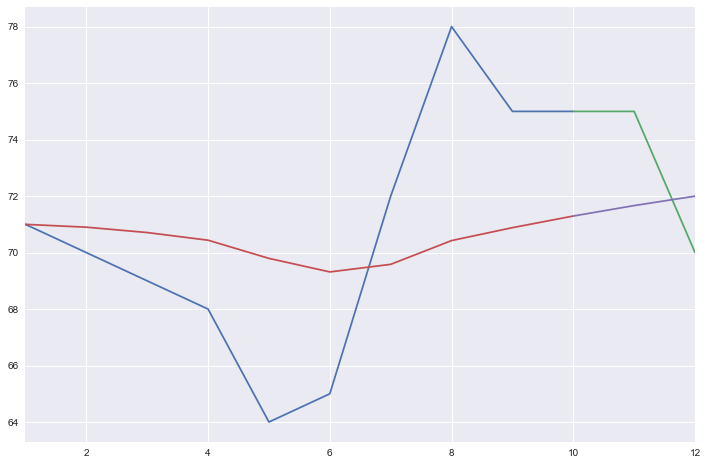

In [78]:
# Let's pretend we only have the first ten samples of Y and the last two will be observed later
ewma_10 = Y[:10].ewm(alpha=0.1, adjust=False).mean()

# Predictions...
alpha = 0.1
pred10 = ewma_10[10]
pred11 = alpha*Y[10] + (1-alpha)*pred10
pred12 = alpha*Y[10] + (1-alpha)*pred11 

# For plotting
S_pred = pd.Series(data=[pred10, pred11, pred12], index=Y.index[-3:])

fig = plt.figure(figsize=(12,8))
Y[:10].plot()
Y[-3:].plot()
ewma_10.plot()
S_pred.plot()
plt.show()

In [79]:
S_pred

10    71.294759
11    71.665283
12    71.998754
dtype: float64

In [80]:
prediction_error = abs_error(Y[10:], S_pred[1:])
print prediction_error

5.33347172609


In [81]:
print rate_prediction(Y[9:], S_pred)

0.937475673779


### Double and Triple Exponential Smoothing
<br>
 
OVERALL SMOOTHING:
$$ S_t=\alpha \frac{y_t}{I_{t-L}} + (1−α)(S_{t−1} + b_{t-1}) $$

TREND SMOOTHING:
$$ b_t = \gamma(S_t - S_{t-1}) + (1-\gamma)b_{t-1} $$

SEASONAL SMOOTHING:
$$ I_t = \beta \frac{y_t}{S_t} + (1-\beta)I_{t-L} $$

FORECAST:
$$ F_{t+m} = (S_t + m b_t) I_{t-L+m} $$

 where
 * $y$ is the observation
 * $S$ is the smoothed observation
 * $b$ is the trend factor
 * $I$ is the seasonal index
 * $F$ is the forecast at m periods ahead
 
 $\alpha$, $\beta$ and $\gamma$ are constants that must be estimated.


### We will not go into Double or Triple Exponential Smoothing.  Neither Pandas nor in Statsmodels has this functionality.  (Personally, I am still surprised by this fact.)

<br>
## Now for a realistic dataset
<br>

In [82]:
#df3 = pd.read_csv("C:/data/timeseries/Monthly_Mean_CO2_Concentrations.csv")
df3 = my_reader.read_csv("Monthly_Mean_CO2_Concentrations.csv")
df3.head(15)

,CO2,Year&Month,Year,Month
0,333.13,1974.38,1974,5
1,332.09,1974.46,1974,6
2,331.10,1974.54,1974,7
3,329.14,1974.63,1974,8
4,327.36,1974.71,1974,9
5,327.29,1974.79,1974,10
6,328.23,1974.88,1974,11
7,329.55,1974.96,1974,12
8,330.62,1975.04,1975,1
9,331.40,1975.13,1975,2


In [83]:
df3.tail(15)

,CO2,Year&Month,Year,Month
146,347.44,1986.54,1986,7
147,345.55,1986.63,1986,8
148,344.21,1986.71,1986,9
149,343.67,1986.79,1986,10
150,345.09,1986.88,1986,11
151,346.27,1986.96,1986,12
152,347.33,1987.04,1987,1
153,347.82,1987.13,1987,2
154,349.29,1987.21,1987,3
155,350.91,1987.29,1987,4


In [84]:
df3.describe()

,CO2,Year&Month,Year,Month
count,161.000000,161.000000,161.000000,161.000000
mean,339.132547,1981.043354,1980.540373,6.515528
std,6.047047,3.885056,3.900311,3.418892
min,327.290000,1974.380000,1974.000000,1.000000
25%,334.090000,1977.710000,1977.000000,4.000000
50%,339.200000,1981.040000,1981.000000,7.000000
75%,344.110000,1984.380000,1984.000000,9.000000
max,351.710000,1987.710000,1987.000000,12.000000


In [85]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 4 columns):
CO2           161 non-null float64
Year&Month    161 non-null float64
Year          161 non-null int64
Month         161 non-null int64
dtypes: float64(2), int64(2)
memory usage: 5.1 KB


### We need to convert the Year and Month columns into a single index column for our time series
<br>

In [86]:
# Note that the Year and Month data types are 'int'
# Therefore we can convert them directly to strings and use them in the "to_datetime" function.
# If Year and Month are floats, then cast them to ints prior to making them strings for the "to_datetime" function.
dates = pd.to_datetime(df3["Year"].astype(str) + "-" + df3["Month"].astype(str))
values = df3["CO2"].get_values()
co2_ts = pd.Series(data=values, index=dates)
co2_ts.head(15)

1974-05-01    333.13
1974-06-01    332.09
1974-07-01    331.10
1974-08-01    329.14
1974-09-01    327.36
1974-10-01    327.29
1974-11-01    328.23
1974-12-01    329.55
1975-01-01    330.62
1975-02-01    331.40
1975-03-01    331.87
1975-04-01    333.18
1975-05-01    333.92
1975-06-01    333.43
1975-07-01    331.85
dtype: float64

(<matplotlib.axes._subplots.AxesSubplot at 0x106ec668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11804780>)

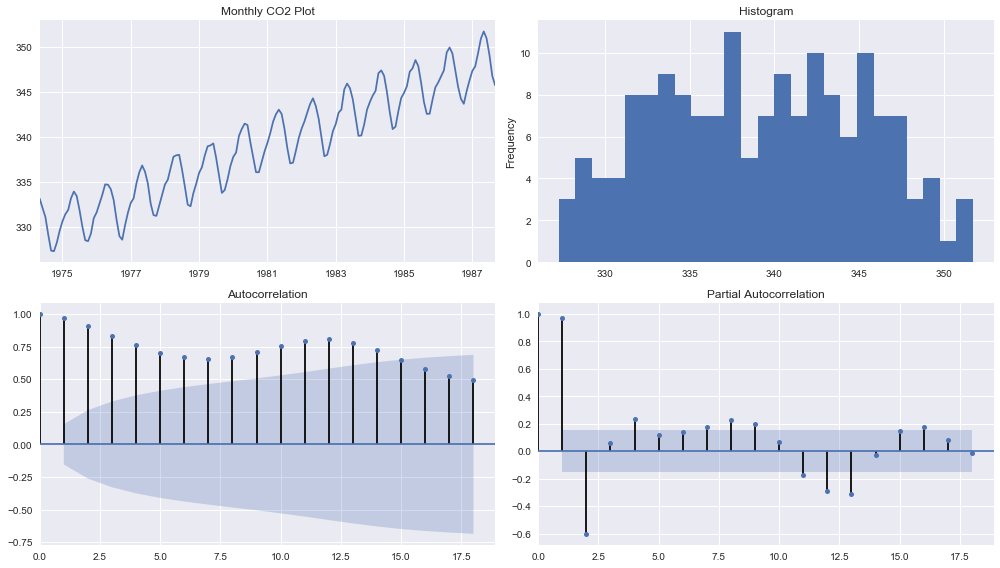

In [87]:
tsplot(co2_ts, lags=18, title='Monthly CO2 Plot')

### Stationary
All forecasting relies upon being able to predict the future from the past.

After accounting for trends in the data and seasonality/cycles, the remaining time series should be stationary for most modeling approaches to be successful.  (A process is stationary (actually "wide sense stationary") if its mean and variance are not changing with time.)  If the mean and variance are changing with time, then the past might not be a good indicator of the future.

#### This time series is clearly not stationary
<br>

In [88]:
df_co2 = pd.DataFrame(data=co2_ts.get_values(), index=co2_ts.index, columns=['CO2'])

In [89]:
df_co2.head()

,CO2
1974-05-01,333.13
1974-06-01,332.09
1974-07-01,331.10
1974-08-01,329.14
1974-09-01,327.36


#### Here are some techniques I have collected to view "seasonal subseries" plots

In [90]:
df_co2["Dates"] = df_co2.index
df_co2["Months"] = df_co2.index.month
df_co2.head()

,CO2,Dates,Months
1974-05-01,333.13,1974-05-01,5
1974-06-01,332.09,1974-06-01,6
1974-07-01,331.10,1974-07-01,7
1974-08-01,329.14,1974-08-01,8
1974-09-01,327.36,1974-09-01,9


In [91]:
df_monthly = df_co2.pivot(index='Dates', columns='Months', values='CO2')

In [92]:
print df_monthly.head(12)

Months          1      2       3       4       5       6      7       8   \
Dates                                                                      
1974-05-01     NaN    NaN     NaN     NaN  333.13     NaN    NaN     NaN   
1974-06-01     NaN    NaN     NaN     NaN     NaN  332.09    NaN     NaN   
1974-07-01     NaN    NaN     NaN     NaN     NaN     NaN  331.1     NaN   
1974-08-01     NaN    NaN     NaN     NaN     NaN     NaN    NaN  329.14   
1974-09-01     NaN    NaN     NaN     NaN     NaN     NaN    NaN     NaN   
1974-10-01     NaN    NaN     NaN     NaN     NaN     NaN    NaN     NaN   
1974-11-01     NaN    NaN     NaN     NaN     NaN     NaN    NaN     NaN   
1974-12-01     NaN    NaN     NaN     NaN     NaN     NaN    NaN     NaN   
1975-01-01  330.62    NaN     NaN     NaN     NaN     NaN    NaN     NaN   
1975-02-01     NaN  331.4     NaN     NaN     NaN     NaN    NaN     NaN   
1975-03-01     NaN    NaN  331.87     NaN     NaN     NaN    NaN     NaN   
1975-04-01  

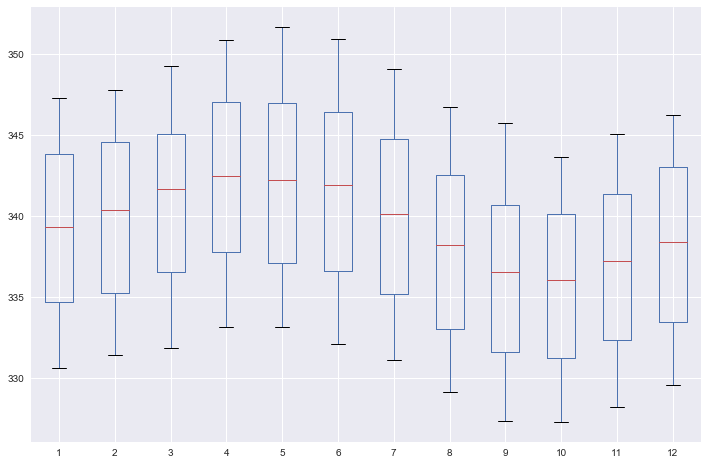

In [93]:
df_monthly.plot.box(figsize=(12,8))
plt.show()

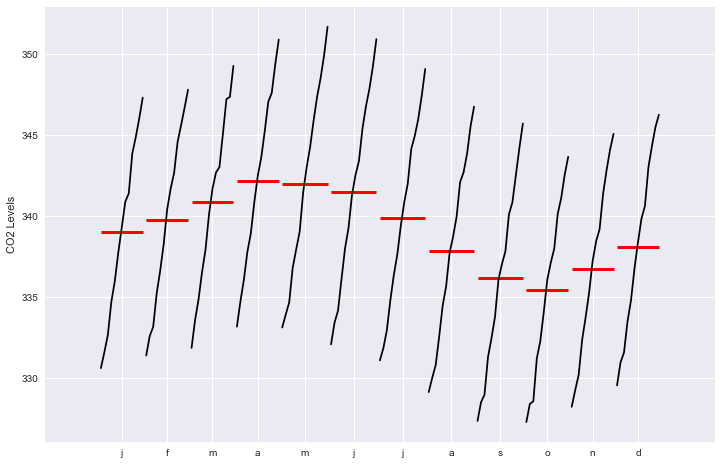

In [94]:
fig = tsaplots.month_plot(df_co2['CO2'], ylabel='CO2 Levels')
fig.set_size_inches(2*fig.get_figwidth(), 2*fig.get_figheight())
plt.show()

#### A Note regarding the statsmodel seasonal subseries plot
Statsmodels appears to sort each month by increasing values from left to right.  Therefore the seasonal subseries plot produced by statsmodels differs from the seasonal subseries plot generated by some other software.  Compare the plot above to corresponding plot part way down this [web page](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm "Seasonal Subseries Plot")

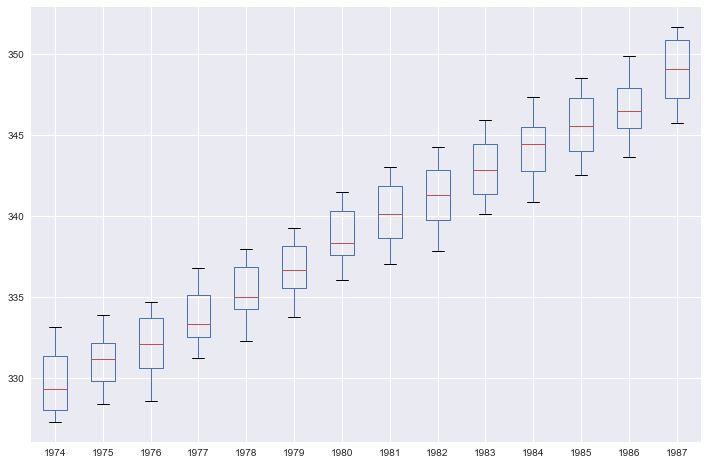

In [95]:
df_co2["Years"] = df_co2.index.year
df_yearly = df_co2.pivot(index='Dates', columns='Years', values='CO2')
df_yearly.plot.box(figsize=(12,8))
plt.show()

## ARMA Approach
<br>
$$ Y_t = K + a_1 X_{t-1} + ... + a_p X_{t-p} +
         W_t - \theta_1 W_{t-1} - ... - \theta_q W_{t-q}$$
<br>
where
$$ K = (1 - \sum_{i=1}^{p} a_i) \mu $$

### Manual Procedure

* Remove Trend and Seasonality
* Check Stationarity
 * If not stationary, difference until have a stationary time series
* Identify the AR order (p) and the MA order (q)
 * Use Autocorrelation and Partial Autocorrelation Plots
    
| Shape | Model |
|-------|-------|
| Exponential Decay to zero | AR(p).  Choose p where PACF becomes zero. |
| Alternating decay to zero | AR(p).  Choose p where PACF becomes zero. |
| Decay after a few lags    | ARMA model                                |
| Some spikes, rest zero    | MA(q).  Choose q where ACF becomes zero.  |
| All zero                  | Random data...white noise.                |
| High Periodic Values      | Include a seasonal AR term.               |
| No decay to zero          | Series is not stationary.                 |


#### SIDE NOTES:
* ARMA models with seasonal components are called SARMA models.
* ARMA models with differencing are called ARIMA models.

(<matplotlib.axes._subplots.AxesSubplot at 0x12289400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12549eb8>)

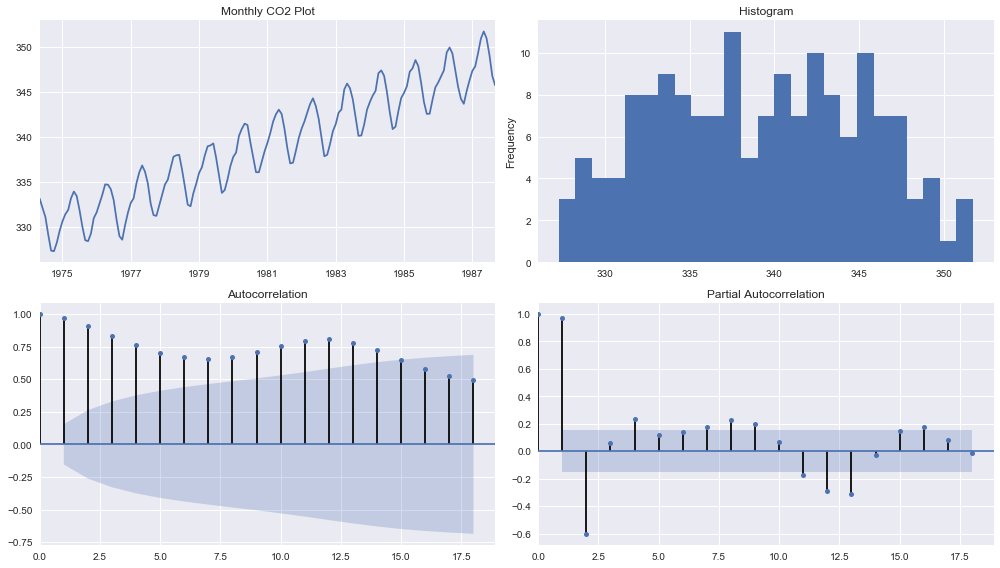

In [96]:
tsplot(co2_ts, lags=18, title='Monthly CO2 Plot')

(<matplotlib.axes._subplots.AxesSubplot at 0x12812908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112c61d0>)

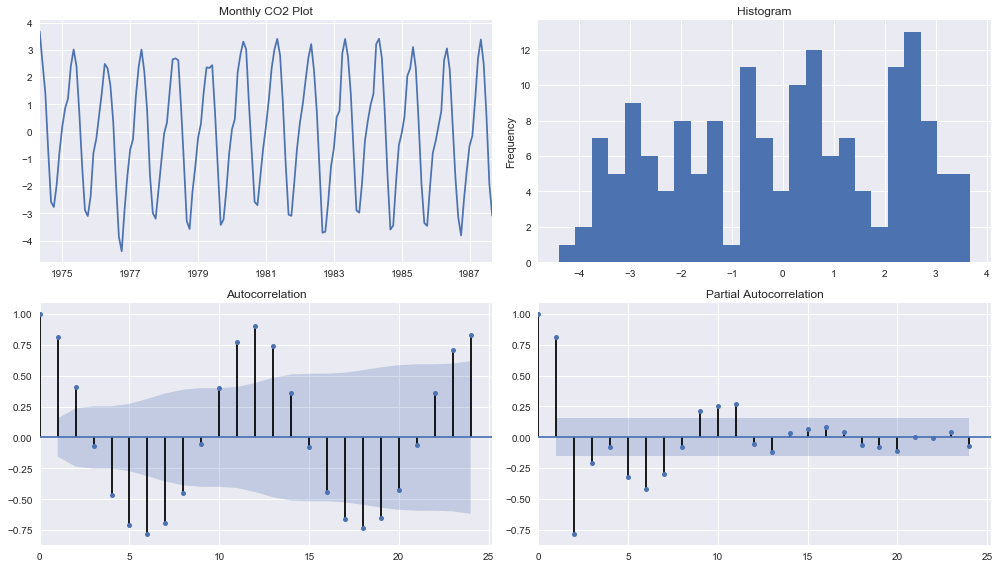

In [97]:
# Remove Linear Trend
detrended_ndarray = smt.detrend(co2_ts, order=1)
detrended_co2 = pd.Series(data=detrended_ndarray, index=co2_ts.index)
tsplot(detrended_co2, lags=24, title='Monthly CO2 Plot')

(<matplotlib.axes._subplots.AxesSubplot at 0x11d27080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10d68dd8>)

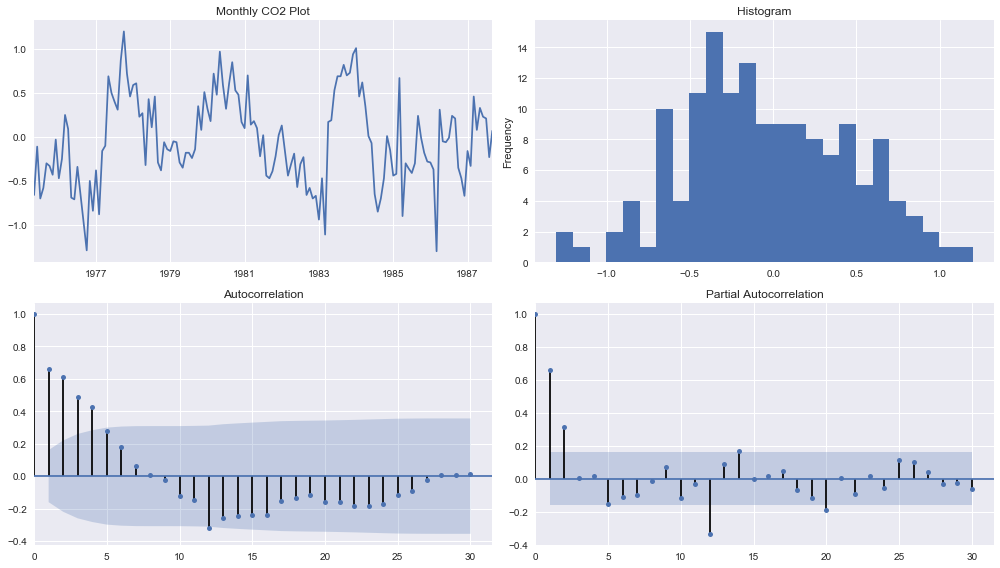

In [98]:
# Check stationarity of annual differenced series
diff12 = detrended_co2.diff(12)[12:]
tsplot(diff12, lags=30, title='Monthly CO2 Plot')

Running Augmented Dickey-Fuller test with paramters:
maxlag: 18
regression: c
autolag: None


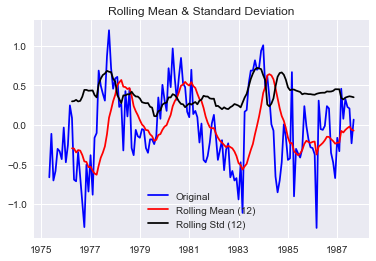

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.436964
p-value                          0.009761
#Lags Used                      18.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


Test Statistic                  -3.436964
p-value                          0.009761
#Lags Used                      18.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64

In [99]:
test_stationarity(diff12, maxlag=18, window=12, plot=True, verbose=True)

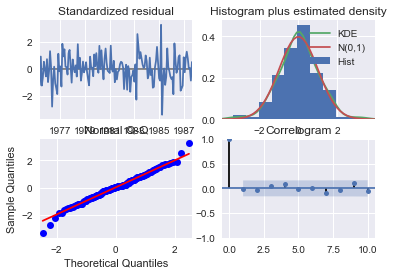

In [100]:
plt.figure(figsize=(12,8))
smodel = smt.statespace.SARIMAX(detrended_co2, order=(2,0,0), seasonal_order=(1, 1, 0, 12), trend='c').fit()
smodel.plot_diagnostics();

In [101]:
sm.stats.durbin_watson(smodel.resid.values)

0.88439373110570008

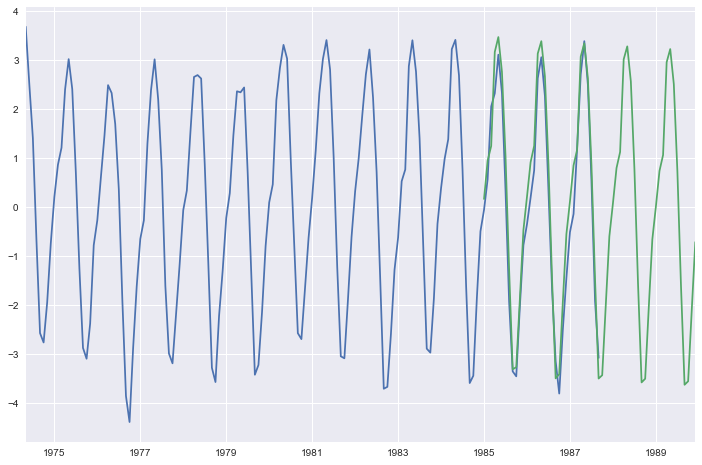

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
ax = detrended_co2.plot(ax=ax)

predict_co2 = smodel.predict('1985-01-01', '1989-12-01', dynamic=True, ax=ax, plot_insample=False)
predict_co2.plot()
plt.show()

### Yeah, but there is a "seasonal_decompose" function.  Why not use this?
<br>
In my view, this function does a good job extracting the seasonal component, but [see this note](http://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html "This is a naive decomposition. More sophisticated methods should be preferred.")


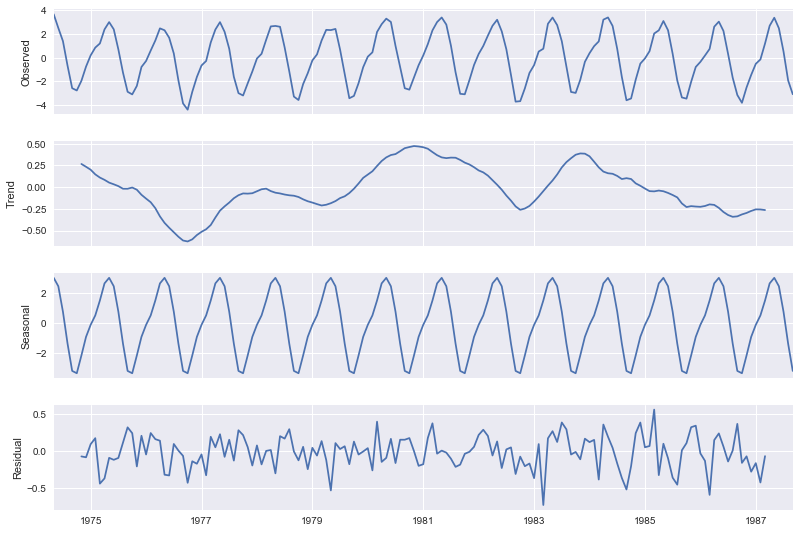

In [103]:
co2_model = smt.seasonal_decompose(detrended_co2)
fig = co2_model.plot()
fig.set_size_inches(2*fig.get_figwidth(), 2*fig.get_figheight())
plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x1497ff98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x153e4b38>)

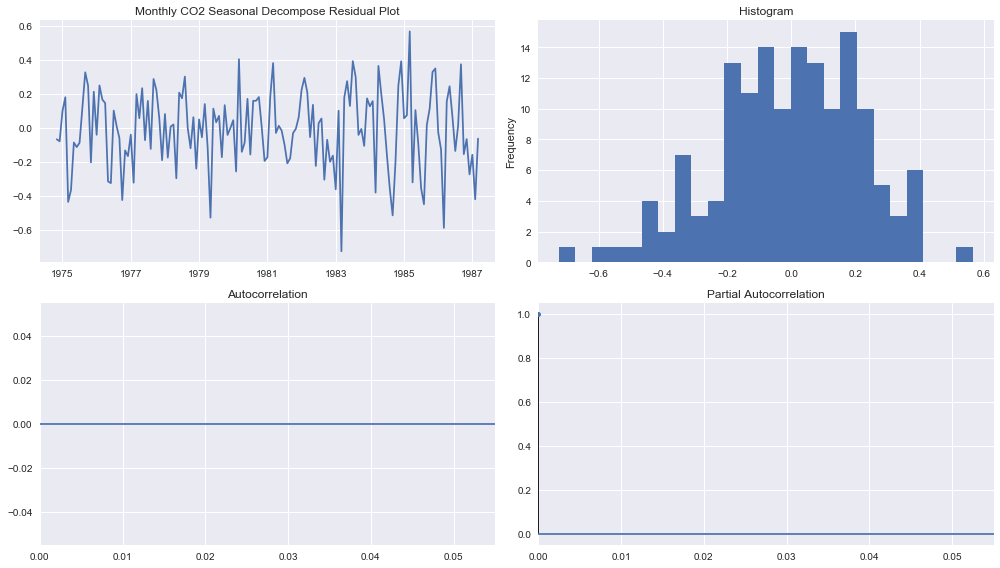

In [104]:
tsplot(co2_model.resid, lags=24, title='Monthly CO2 Seasonal Decompose Residual Plot')

#### Notice the Autocorrelation and the Partial Autocorrelation appear to be missing.  Something is amiss....

In [105]:
dtemp = np.array([detrended_co2, co2_model.trend, co2_model.seasonal, co2_model.resid]).T
decomp=pd.DataFrame(data=dtemp, index=detrended_co2.index, columns=['detrended CO2', 'T', 'S', 'R'])
decomp.head(20)

,detrended CO2,T,S,R
1974-05-01,3.676894,NaN,3.048466,NaN
1974-06-01,2.515901,NaN,2.483535,NaN
1974-07-01,1.404908,NaN,0.778292,NaN
1974-08-01,-0.676085,NaN,-1.360909,NaN
1974-09-01,-2.577078,NaN,-3.186742,NaN
1974-10-01,-2.768071,NaN,-3.342958,NaN
1974-11-01,-1.949064,0.267186,-2.149451,-0.066799
1974-12-01,-0.750057,0.234943,-0.906342,-0.078658
1975-01-01,0.198950,0.201034,-0.100605,0.098521
1975-02-01,0.857957,0.147541,0.530581,0.179835


In [106]:
decomp.tail(20)

,detrended CO2,T,S,R
1986-02-01,0.186880,-0.216870,0.530581,-0.126831
1986-03-01,0.745887,-0.198280,1.530581,-0.586415
1986-04-01,2.624894,-0.204273,2.675549,0.153617
1986-05-01,3.053901,-0.238599,3.048466,0.244034
1986-06-01,2.262908,-0.286259,2.483535,0.065631
1986-07-01,0.321915,-0.321002,0.778292,-0.135376
1986-08-01,-1.689078,-0.341578,-1.360909,0.013409
1986-09-01,-3.150071,-0.336321,-3.186742,0.372992
1986-10-01,-3.811064,-0.313981,-3.342958,-0.154126
1986-11-01,-2.512057,-0.297057,-2.149451,-0.065549


### How would I proceed if using the seasonal_decompose function for an additive model?

* Remove the linear trend, if any, as above.
* Use the seasonal decompose function to get the periodic seasonal component
* Remove the seasonl component from the detrended time series
* Use the ARMA or ARIMA model to the detrended, decycled series
* Call the predict method on the ARMA (or ARIMA) model
* Extrapolate the seasonal component forward in time
* Extrapolate the linear trend in time
* Add the linear trend + seasonal component to the prediction from the ARMA or ARIMA model

## Useful Resources

* Engineering Statistic Handbook, [Chapeter 6.4 Introduction to Time Series Analysis](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm)
* Statistical Forecasting: [Notes on Regression and Time Series Analysis] (http://people.duke.edu/~rnau/411home.htm)
* The online text [Forecasting: Principles and Practice] (https://www.otexts.org/fpp)
* Various Tutorials at Analytics Vidhya, such as this [tutorial in R] (https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)
* Various [time series] (http://machinelearningmastery.com/category/time-series/) articles at Machine Learning Mastery

I'm certain that I've missed a number of useful resources that I have consulted along the way.  I'll attempt to update this section of the notebook on occasion with online information that others might find useful when getting started with time series analysis.
<br>

### Now try the Southern Oscillations Data Set
<br>

In [107]:
df4 = my_reader.read_csv("Southern_Oscillations.csv")
df4.head(15)

,Unnamed: 0,Southern Oscillation,Year,Month
0,1,-0.7,1955.0,1.0
1,2,1.3,1955.0,2.0
2,3,0.1,1955.0,3.0
3,4,-0.9,1955.0,4.0
4,5,0.8,1955.0,5.0
5,6,1.6,1955.0,6.0
6,7,1.7,1955.0,7.0
7,8,1.4,1955.0,8.0
8,9,1.4,1955.0,9.0
9,10,1.5,1955.0,10.0


In [108]:
df4.tail()

,Unnamed: 0,Southern Oscillation,Year,Month
451,489,0.0,1992.0,8.0
452,490,0.0,1992.0,9.0
453,491,-1.9,1992.0,10.0
454,492,-0.9,1992.0,11.0
455,493,-1.1,1992.0,12.0


In [109]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 4 columns):
Unnamed: 0              456 non-null int64
Southern Oscillation    456 non-null float64
Year                    456 non-null float64
Month                   456 non-null float64
dtypes: float64(3), int64(1)
memory usage: 14.3 KB


In [110]:
so_dates = pd.to_datetime(df4["Year"].astype(int).astype(str) + "-" + df4["Month"].astype(int).astype(str))
values = df4["Southern Oscillation"].get_values()
so_ts = pd.Series(data=values, index=so_dates)
so_ts.head(15)

1955-01-01   -0.7
1955-02-01    1.3
1955-03-01    0.1
1955-04-01   -0.9
1955-05-01    0.8
1955-06-01    1.6
1955-07-01    1.7
1955-08-01    1.4
1955-09-01    1.4
1955-10-01    1.5
1955-11-01    1.4
1955-12-01    0.9
1956-01-01    1.2
1956-02-01    1.1
1956-03-01    0.9
dtype: float64

In [111]:
so_ts.index

DatetimeIndex(['1955-01-01', '1955-02-01', '1955-03-01', '1955-04-01',
               '1955-05-01', '1955-06-01', '1955-07-01', '1955-08-01',
               '1955-09-01', '1955-10-01',
               ...
               '1992-03-01', '1992-04-01', '1992-05-01', '1992-06-01',
               '1992-07-01', '1992-08-01', '1992-09-01', '1992-10-01',
               '1992-11-01', '1992-12-01'],
              dtype='datetime64[ns]', length=456, freq=None)

(<matplotlib.axes._subplots.AxesSubplot at 0x15a9b198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15ed6390>)

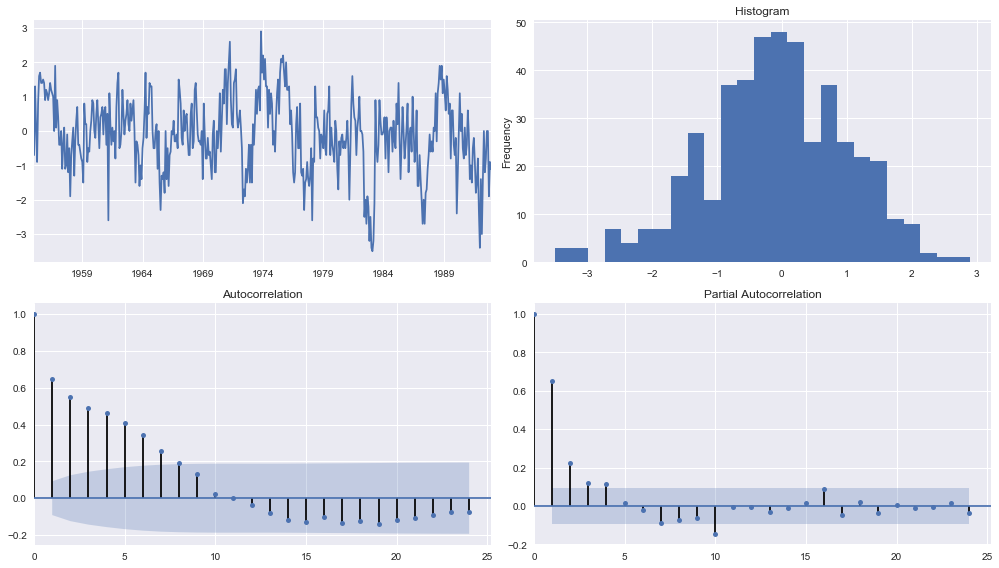

In [112]:
tsplot(so_ts, lags=24)

#### The ACF shows alternating decay to zero.
#### The PACF has two obviously significant lags.
#### Start with an AR(2) Model.

In [113]:
# See Above.  The following function is defined...
#
# def choose_AR_model_order(ts, maxlag=6, ic='bic'):
#     '''Return the AR model order that minimizes the chosen information criterion'''
#     ar_model_order = sm.tsa.AR(ts).select_order(maxlag=maxlag, ic=ic)
#     return ar_model_order

# Note that the maximum lag might impact the chosen model order.
# Using a maxlag of 6 statsmodels returns a model order of 2 using "BIC"
model_order_bic = choose_AR_model_order(so_ts, maxlag=6, ic='bic')
model_order_aic = choose_AR_model_order(so_ts, maxlag=6, ic='aic')
print model_order_aic, model_order_bic

4 2


In [114]:
# Using a maxlag of 12 statsmodels returns a model order of 4 using "BIC"
model_order_aic = choose_AR_model_order(so_ts, maxlag=12, ic='aic')
model_order_bic = choose_AR_model_order(so_ts, maxlag=12, ic='bic')
print model_order_aic, model_order_bic

10 4


In [115]:
so_ar_model = smt.AR(so_ts, freq='M')
model_order = so_ar_model.select_order(maxlag=6, ic='bic')
print model_order
so_ar2 = so_ar_model.fit(maxlag=model_order)

2


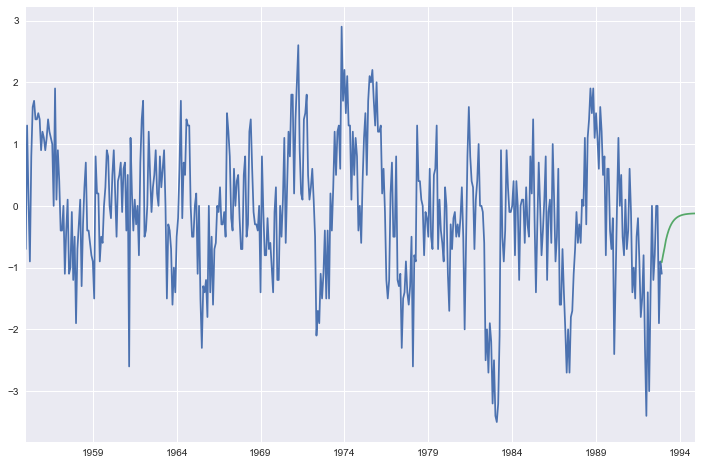

In [116]:
fig, ax = plt.subplots(figsize=(12,8))
ax = so_ts.plot(ax=ax)

# start_month = pd.to_datetime('1992-12', format='%Y-%m')
# end_month = pd.to_datetime('1995-01', format='%Y-%m')

predict_so = so_ar2.predict('1992-12', '1995-01')
predict_so.plot()
plt.show()

[DataSets](http://www.stat.purdue.edu/~chong/stat520/bjr-data/)

## An Attempt To Recreate [6.4.4.9. Example of Univariate Box-Jenkins Analysis](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc449.htm "Example using Series F data set")

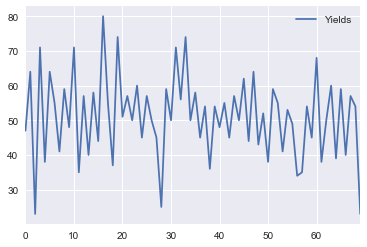

In [117]:
df5 = my_reader.read_csv("series_F.csv")
df5.plot()

In [118]:
df5.describe()

,Yields
count,70.000000
mean,51.128571
std,11.908980
min,23.000000
25%,44.000000
50%,51.500000
75%,58.000000
max,80.000000


In [119]:
df5.index

RangeIndex(start=0, stop=70, step=1)

#### Note: If we are using a Series as input to statsmodels, the Series must have date indices.
<br>

In [120]:
# Create a Series with artificial time indices.  Using a frequency of 1 day and an arbitrary starting day.
yield_ts = pd.Series(data=df5['Yields'].get_values(), index=pd.date_range(start='2017-01-01', periods=len(df5.index)))

In [121]:
yield_ts.describe()

count    70.000000
mean     51.128571
std      11.908980
min      23.000000
25%      44.000000
50%      51.500000
75%      58.000000
max      80.000000
dtype: float64

In [122]:
print yield_ts.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
      

Running Augmented Dickey-Fuller test with paramters:
maxlag: 20
regression: c
autolag: None


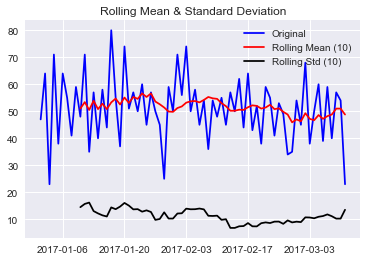

Results of Augmented Dickey-Fuller Test:
Test Statistic                  0.617743
p-value                         0.988045
#Lags Used                     20.000000
Number of Observations Used    49.000000
Critical Value (5%)            -2.922629
Critical Value (1%)            -3.571472
Critical Value (10%)           -2.599336
dtype: float64


Test Statistic                  0.617743
p-value                         0.988045
#Lags Used                     20.000000
Number of Observations Used    49.000000
Critical Value (5%)            -2.922629
Critical Value (1%)            -3.571472
Critical Value (10%)           -2.599336
dtype: float64

In [123]:
test_stationarity(yield_ts, maxlag=20, window=10, plot=True, verbose=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x148d5978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1796a710>)

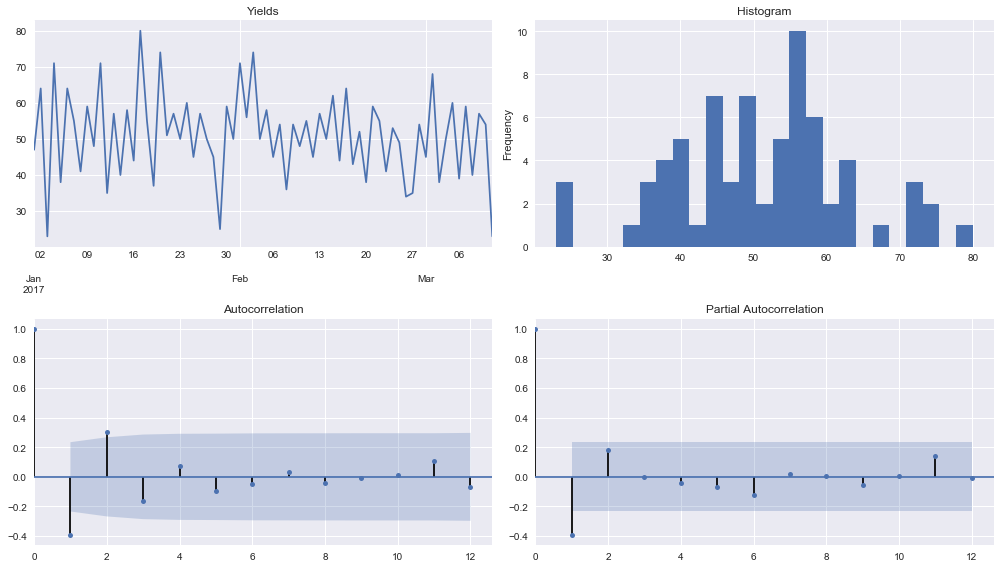

In [124]:
tsplot(yield_ts, lags=12, title='Yields')

#### Choose AR(2) Model

Even though the Partial Autocorrelation only has 1 significant lag, the Autocorrelation oscillates between positive and negative.  If this were an AR(1) model, the Autocorrelation would remain positive.  The model order must be at least 2.  Therefore the ACF and PACF together indicate that an AR(2) model is appropriate for this time series.

In [126]:
# yield_ar_model = smt.AR(yield_ts, dates=yield_ts.index, freq='1D')
yield_ar_model = smt.AR(yield_ts)
yield_ar2 = yield_ar_model.fit(maxlag=2, ic='bic', trend='nc')
print yield_ar2.params

L1.y    0.222296
L2.y    0.751307
dtype: float64


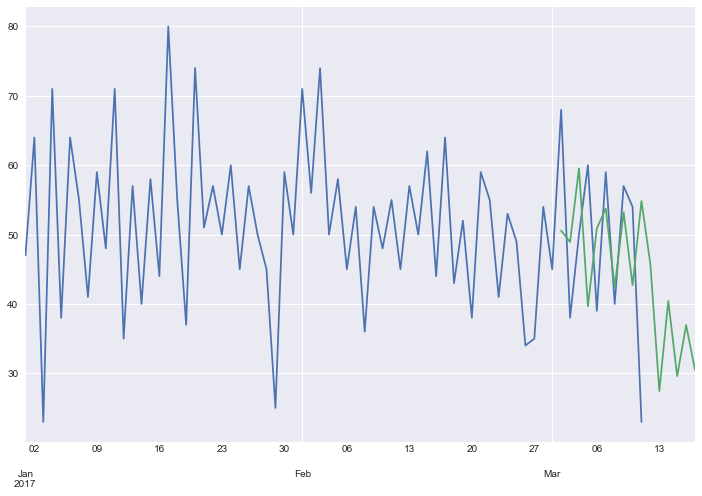

In [127]:
fig, ax = plt.subplots(figsize=(12,8))
ax = yield_ts.plot(ax=ax)

predict_so = yield_ar2.predict(start='2017-03-02', end='2017-03-17')
predict_so.plot()
plt.show()